# Notes on Chapter 2 of Statistical Rethinking 2nd Edition by Richard McElreath

In [1]:
from math import pi
import time

import jax
from jax import numpy as jnp
from jax import scipy as jsp
from jax import random as jrandom
from jax.scipy import optimize as jspopt
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import math as tfm
from tensorflow_probability import distributions as tfd
from tensorflow_probability.substrates import jax as jtfp
from tensorflow_probability.substrates.jax import distributions as jtfd

2024-03-22 21:47:48.877449: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-22 21:47:48.877489: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-22 21:47:48.878158: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-22 21:47:49.452438: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
%load_ext rpy2.ipython

### 2.1

In [3]:
%%R

ways <- c(0, 3, 8, 9, 0)
ways/sum(ways)

[1] 0.00 0.15 0.40 0.45 0.00


In [4]:
ways = tf.constant([0, 3, 8, 9, 0], dtype=tf.float16)
ways/tfm.reduce_sum(ways)

2024-03-22 21:47:51.260522: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-03-22 21:47:51.262225: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


<tf.Tensor: shape=(5,), dtype=float16, numpy=array([0.  , 0.15, 0.4 , 0.45, 0.  ], dtype=float16)>

In [5]:
jways = jnp.array([0, 3, 8, 9, 0], dtype=jnp.float16)
jways/jways.sum()

Array([0.  , 0.15, 0.4 , 0.45, 0.  ], dtype=float16)

### 2.2

In [6]:
%%R

dbinom(6, size=9, prob=0.5)

[1] 0.1640625


In [7]:
float(tfd.Binomial(total_count=9, probs=0.5).prob(6))

0.1640627086162567

In [8]:
jtfd.Binomial(total_count=9, probs=0.5).prob(6)

Array(0.1640624, dtype=float32)

### 2.3

In [9]:
%%R

p_grid <- seq(from=0, to=1, length.out=20)
prior <- rep(1, 20)
likelihood <- dbinom(6, size=9, prob=p_grid)
unstd.posterior <- likelihood * prior
posterior <- unstd.posterior/ sum(unstd.posterior)

In [10]:
p_grid = tf.linspace(0., 1, 20)
prior = tf.ones_like(p_grid)
likelihood = tfd.Binomial(total_count=9, probs=p_grid).prob(6)
unnormalized_posterior = likelihood * prior
posterior = unnormalized_posterior / tfm.reduce_sum(unnormalized_posterior)

In [11]:
jp_grid = jnp.linspace(0., 1, 20)
jprior = jnp.ones_like(jp_grid)
jlikelihood = jtfd.Binomial(total_count=9, probs=jp_grid).prob(6)
junnormalize_posterior = jlikelihood * jprior
jposterior = junnormalize_posterior / junnormalize_posterior.sum()

### 2.4

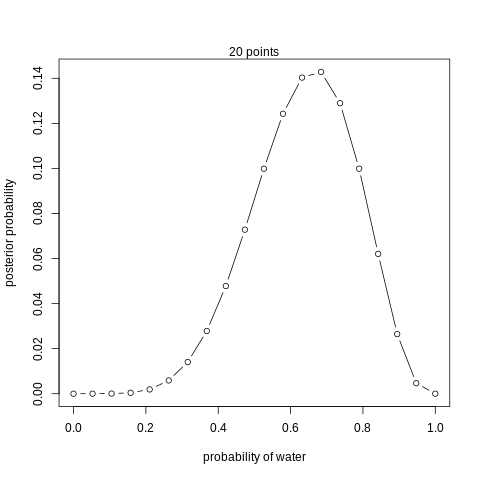

In [12]:
%%R

plot(p_grid, posterior, type="b", xlab="probability of water", 
     ylab="posterior probability")
mtext("20 points")

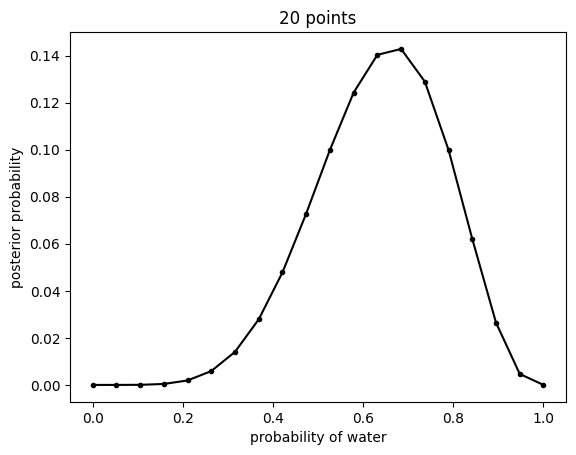

In [13]:
plt.plot(p_grid, posterior, "k.-")
plt.xlabel("probability of water")
plt.ylabel("posterior probability")
plt.title(f'{len(p_grid)} points');

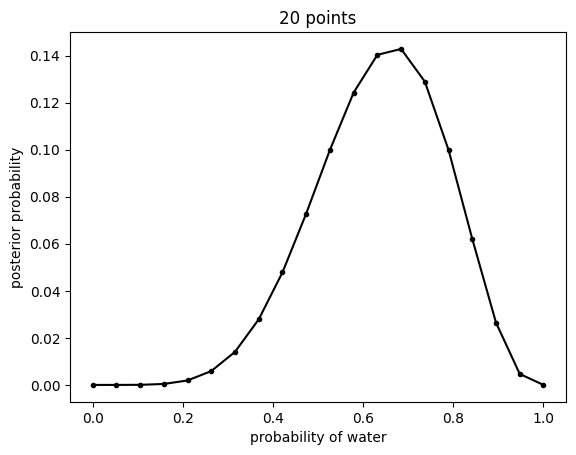

In [14]:
plt.plot(jp_grid, posterior, "k.-")
plt.xlabel("probability of water")
plt.ylabel("posterior probability")
plt.title(f'{len(p_grid)} points');

### 2.5


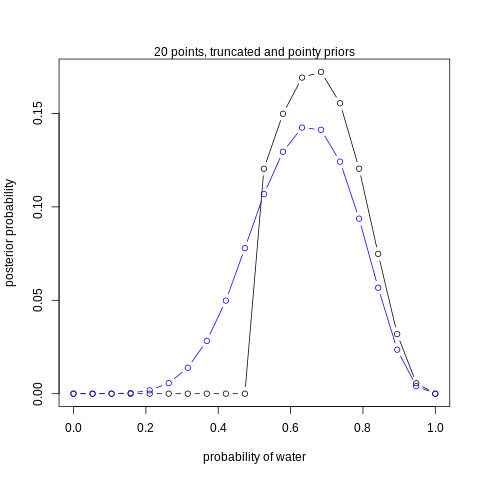

In [15]:
%%R

p_grid <- seq(from=0, to=1, length.out=20)

prior <- ifelse(p_grid < 0.5, 0, 1)
likelihood <- dbinom(6, size=9, prob=p_grid)
unstd.posterior <- likelihood * prior
posterior <- unstd.posterior/ sum(unstd.posterior)
plot(p_grid, posterior, type="b", xlab="probability of water", 
     ylab="posterior probability")

prior <- exp(-0.5*abs(p_grid - 0.5))
likelihood <- dbinom(6, size=9, prob=p_grid)
unstd.posterior <- likelihood * prior
posterior <- unstd.posterior/ sum(unstd.posterior)
lines(p_grid, posterior, type="b", col="blue")

mtext("20 points, truncated and pointy priors")

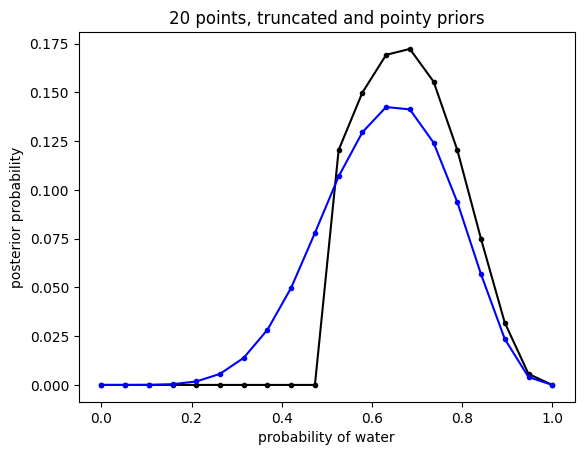

In [16]:
p_grid = tf.linspace(0., 1, 20)

prior = tf.where(p_grid < 0.5, tf.zeros_like(p_grid), tf.ones_like(p_grid))
likelihood = tfd.Binomial(total_count=9, probs=p_grid).prob(6)
unnormalized_posterior = likelihood * prior
posterior = unnormalized_posterior / tfm.reduce_sum(unnormalized_posterior)
plt.plot(p_grid, posterior, ".-k")

prior = tfm.exp(-0.5*tfm.abs(p_grid - 0.5))
likelihood = tfd.Binomial(total_count=9, probs=p_grid).prob(6)
unnormalized_posterior = likelihood * prior
posterior = unnormalized_posterior / tfm.reduce_sum(unnormalized_posterior)
plt.plot(p_grid, posterior, ".-b")

plt.xlabel("probability of water")
plt.ylabel("posterior probability")
plt.title(f'{len(p_grid)} points, truncated and pointy priors');

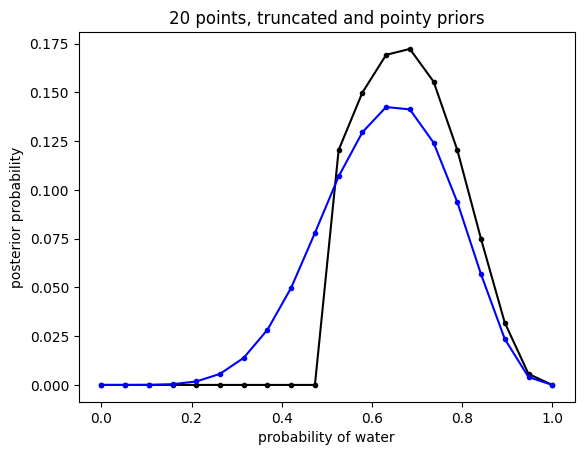

In [17]:
jp_grid = jnp.linspace(0., 1, 20)

jprior = jnp.where(jp_grid < 0.5, jnp.zeros_like(jp_grid), jnp.ones_like(jp_grid))
jlikelihood = jtfd.Binomial(total_count=9, probs=jp_grid).prob(6)
junnormalized_posterior = jlikelihood * jprior
jposterior = junnormalized_posterior / junnormalized_posterior.sum()
plt.plot(jp_grid, jposterior, ".-k")

jprior = jnp.exp(-0.5*jnp.abs(jp_grid - 0.5))
jlikelihood = jtfd.Binomial(total_count=9, probs=jp_grid).prob(6)
junnormalized_posterior = jlikelihood * jprior
jposterior = junnormalized_posterior / junnormalized_posterior.sum()
plt.plot(jp_grid, jposterior, ".-b")

plt.xlabel("probability of water")
plt.ylabel("posterior probability")
plt.title(f'{len(p_grid)} points, truncated and pointy priors');

### 2.6

In [18]:
%%R

library(rethinking)
globe.qa <- quap(
    alist(
        W ~ dbinom(W+L, p),
        p ~ dunif(0, 1)
    ),
    data=list(W=6, L=3)
)

precis(globe.qa)

  mean   sd 5.5% 94.5%
p 0.67 0.16 0.42  0.92


Loading required package: rstan
Loading required package: StanHeaders

rstan version 2.32.6 (Stan version 2.32.2)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)

Loading required package: cmdstanr
This is cmdstanr version 0.7.1
- CmdStanR documentation and vignettes: mc-stan.org/cmdstanr
- Use set_cmdstan_path() to set the path to CmdStan
- Use install_cmdstan() to install CmdStan
Loading required package: parallel
rethinking (Version 2.21)

Attaching package: ‘rethinking’

The following object is masked from ‘package:rstan’:

    stan

The following object is masked from ‘package:stats’:

    rstudent

In addition: Warning messages:
1: In (function (n)  :
  

I don't see an equivalent of the author's library for tensorflow probability, so we'll need to implement the quadratic approximation by hand...

In [19]:
W = tf.constant(6.)
L = tf.constant(3.)

def likelihood(p):
    N = W + L
    return tfd.Binomial(N, probs=p).prob(W) * tfd.Uniform().prob(p)

# Tensorflow gives a lot of warnings that don't have workarounds to avoid 
# the warning; thus we need to disable them manually
def NestedGradientWarningFilter(record):
    return not record.getMessage().startswith(
        'Calling GradientTape.gradient on a persistent tape inside its contex')

# find the point of maximum likelihood
mu = tf.Variable(0.5, 'mu')
optimizer = tf.keras.optimizers.Adam(0.1)
for i in range(100):
    with tf.GradientTape() as tape:
        loss = tfm.negative(tfm.log(likelihood(mu)))
    gradients = tape.gradient(loss, [mu])
    optimizer.apply_gradients(zip(gradients, [mu]))
    
# find the Hessian at that point
with tf.GradientTape(persistent=True) as tape:
    loss = tfm.negative(tfm.log(likelihood(mu)))
    tf.get_logger().addFilter(NestedGradientWarningFilter)
    gradients = tape.gradient(loss, [mu])
    tf.get_logger().removeFilter(NestedGradientWarningFilter)
hessians = tape.jacobian(gradients[0], mu)

sigma = tfm.sqrt(1/hessians)

print("  mean   sd 5.5% 94.5%")
print(f'p {float(mu):.2f} {float(sigma):.2f} {float(mu - 1.6*sigma):.2f} ' +
      f' {float(mu + 1.6*sigma):.2f}')

I0000 00:00:1711144077.674966  226157 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  mean   sd 5.5% 94.5%
p 0.67 0.16 0.42  0.92


JAX provides a minimize function that makes this a little easier to implement:

In [20]:
def quap(log_likelihood, guess):
    def safe_neg_log_likelihood(beta):
        l = log_likelihood(beta)
        return jnp.where(jnp.isfinite(l), -l, 1000+jnp.abs(beta).sum())
    return jspopt.minimize(
        safe_neg_log_likelihood, 
        jnp.asarray(guess),
        method="BFGS"
    )

def log_likelihood(beta):
    W = 6
    L = 3
    return jtfd.Binomial(W+L, probs=beta[0]).log_prob(W)

globe_qa = quap(log_likelihood, [0.5])

In [21]:
mu = float(globe_qa.x[0])
sigma = float(jnp.sqrt(globe_qa.hess_inv[0,0]))

print("  mean   sd 5.5% 94.5%")
print(f'p {float(mu):.2f} {float(sigma):.2f} {float(mu - 1.6*sigma):.2f} ' +
      f' {float(mu + 1.6*sigma):.2f}')

  mean   sd 5.5% 94.5%
p 0.67 0.16 0.42  0.92


### 2.7

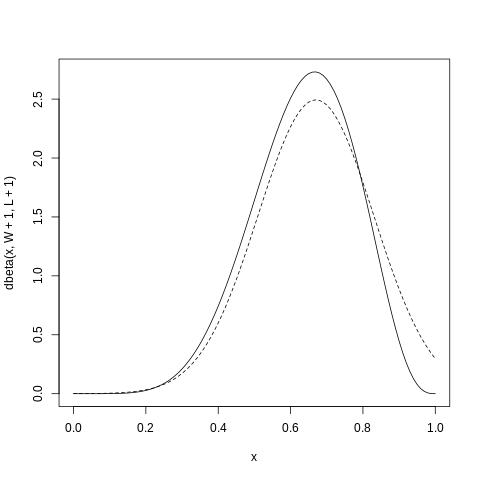

In [22]:
%%R

W <- 6
L <- 3
curve(dbeta(x, W+1, L+1), from=0, to=1)
curve(dnorm(x, 0.67, 0.16), lty=2, add=TRUE)

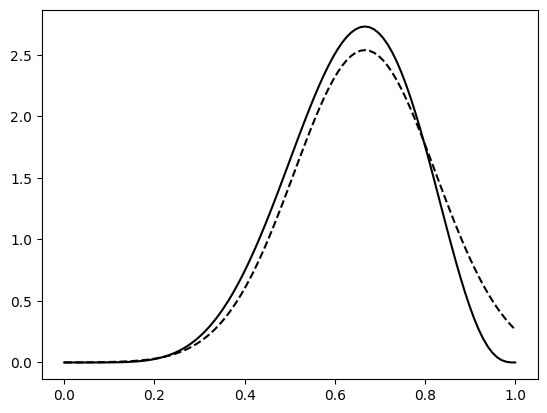

In [23]:
W = 6.
L = 3.
x = tf.linspace(0., 1., 100)
plt.plot(x, tfd.Beta(W + 1, L + 1).prob(x), 'k-')
plt.plot(x, tfd.Normal(mu, sigma).prob(x), 'k--');

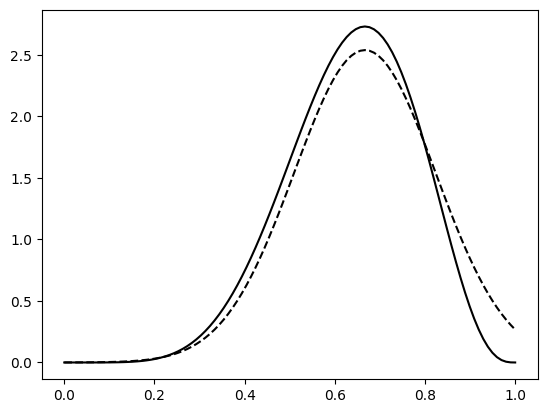

In [24]:
W = 6.
L = 3.
x = jnp.linspace(0., 1., 100)
plt.plot(x, jtfd.Beta(W + 1, L + 1).prob(x), 'k-')
plt.plot(x, jtfd.Normal(mu, sigma).prob(x), 'k--');

### 2.8

In [25]:
%%R

n_samples <- 1000
p <- rep(NA, n_samples)
p[1] <- 0.5
W <- 6
L <- 3
for (i in 2:n_samples) {
    p_new <- rnorm(1, p[i-1], 0.1)
    if (p_new < 0) p_new <- abs(p_new) # reflecting boundaries
    if (p_new > 1) p_new <- 2 - p_new
    q0 <- dbinom(W, W+L, p[i-1])
    q1 <- dbinom(W, W+L, p_new)
    p[i] <- ifelse(runif(1) < q1/q0, p_new, p[i-1])
}

In [26]:
n_samples = 1000
p = [tf.constant(0.5)]
W = 6
L = 3
for i in range(1,n_samples):
    p_new = tfd.Normal(p[-1], 0.1).sample()
    p_new = tfm.abs(p_new)
    p_new = tfm.minimum(p_new, 2 - p_new)
    qprev = tfd.Binomial(W + L, probs=p[-1]).prob(W)
    qnew = tfd.Binomial(W + L, probs=p_new).prob(W)
    p.append(tf.where(tfd.Uniform().sample(p[-1].shape) < qnew/qprev, 
                      p_new, p[-1]))
p = tf.stack(p)

In [27]:
n_samples = 1000
jp = [jnp.array(0.5)]
W = jnp.array(6.)
L = jnp.array(3.)

@jax.jit
def step(p_old, W, L, seed):
    seed1,seed2 = jrandom.split(seed)
    p_new = jtfd.Normal(p_old, 0.1).sample(seed=seed1)
    p_new = jnp.abs(p_new)
    p_new = jnp.minimum(p_new, 2 - p_new)
    qprev = jtfd.Binomial(W + L, probs=jp[-1]).prob(W)
    qnew = jtfd.Binomial(W + L, probs=p_new).prob(W)
    return jnp.where(
        jtfd.Uniform().sample(jp[-1].shape, seed=seed2) < qnew/qprev, 
        p_new,
        p_old
    )
    
key = jrandom.key(42)
for i in range(1,n_samples):
    key,seed = jrandom.split(key)
    jp.append(step(jp[-1], W, L, seed))

jp = jnp.stack(jp)

### 2.9

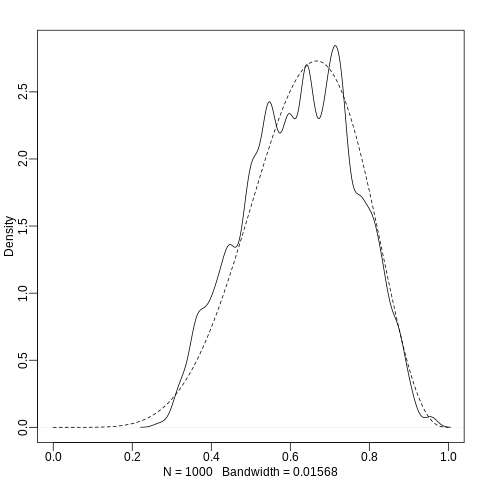

In [28]:
%%R

dens(p, xlim=c(0,1))
curve(dbeta(x, W+1, L+1), lty=2, add=TRUE)

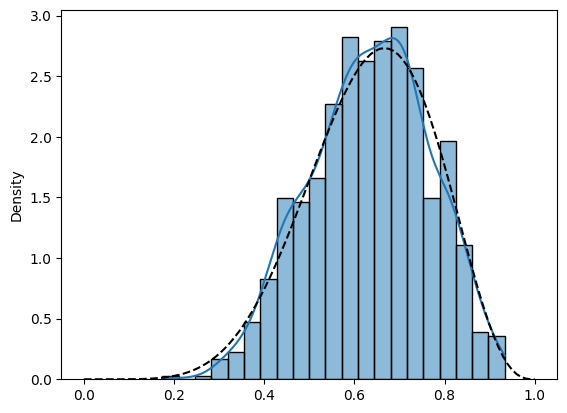

In [29]:
sns.histplot(p, kde=True, stat="density")
x = tf.linspace(0.,1,100)
plt.plot(x, tfd.Beta(W+1, L+1).prob(x), '--k')

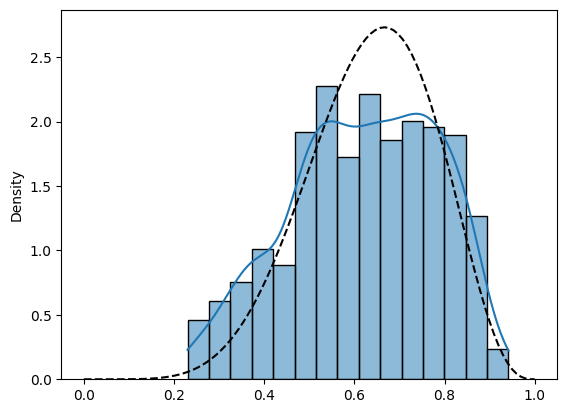

In [30]:
sns.histplot(jp, kde=True, stat="density")
x = jnp.linspace(0.,1,100)
plt.plot(x, jtfd.Beta(W+1, L+1).prob(x), '--k')

### Extension of 2.8-2.9 with vectorized tensorflow code

The advantage of using tensorflow is that we can calculate many trajectories in parallel on one or more GPUs.  This code will calculate one billion samples from the posterior:

In [31]:
# combine the entire step into a function to keep the data on the GPU
@tf.function()
def metropolis_step(p_old, W, L):
    p_new = tfd.Normal(p_old, 0.1).sample()
    p_new = tfm.abs(p_new)
    p_new = tfm.minimum(p_new, 2 - p_new)
    qprev = tfd.Binomial(W + L, probs=p_old).prob(W)
    qnew = tfd.Binomial(W + L, probs=p_new).prob(W)
    return tf.where(tfd.Uniform().sample(p_old.shape) < qnew/qprev,
                    p_new, p_old)

n_samples = 1000
n_replicates = 1000000
runin = 20
p = [0.5*tf.ones(n_replicates)]
W = 6
L = 3

for i in range(1,n_samples + runin):
    p.append(metropolis_step(p[-1], W, L))
    
p = tf.concat(p[runin:], 0)

Because we aren't using parallel code to plot, we'll just plot the first million samples.

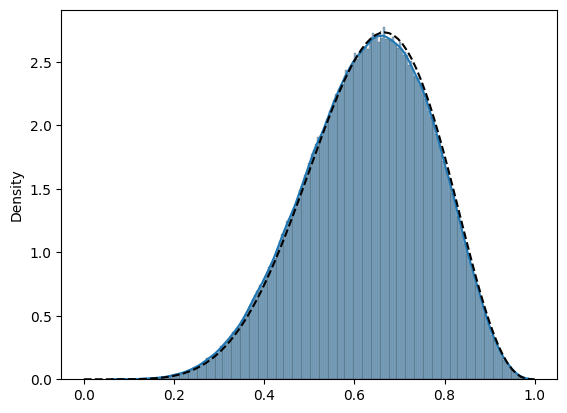

In [32]:
sns.histplot(p[:1000000], kde="True", stat="density")
x = tf.linspace(0.,1,100)
plt.plot(x, tfd.Beta(W+1, L+1).prob(x), '--k');

Here's a slightly messier example which uses 16 bit floating point (for speed/memory efficiency) and uses the real (uniform) prior for p.

In [33]:
# combine the entire step into a function to keep the data on the GPU
@tf.function()
def metropolis_step(p_old, W, L):
    zero_f16 = tf.constant(0., dtype=tf.float16)
    one_f16 = tf.constant(1., dtype=tf.float16)
    step_sd = tf.constant(0.1, dtype=tf.float16)
    p_new = tfd.Normal(p_old, step_sd).sample()
    p_new = tfm.abs(p_new)
    p_new = tfm.minimum(p_new, 2 - p_new)
    qprev = tfd.Binomial(W + L, probs=p_old).prob(W)
    qnew = tfd.Binomial(W + L, probs=p_new).prob(W)
    return tf.where(
        tfd.Uniform(zero_f16, one_f16).sample(p_old.shape) < qnew/qprev,
        p_new,
        p_old)

n_samples = 1000
n_replicates = 1000000
runin = 100
p = [tfd.Uniform(tf.constant(0., dtype=tf.float16),
                 tf.constant(1., dtype=tf.float16)).sample(n_replicates)]
W = 6
L = 3

for i in range(1,n_samples + runin):
    p.append(metropolis_step(p[-1], W, L))
    
p = tf.concat(p[runin:], 0)

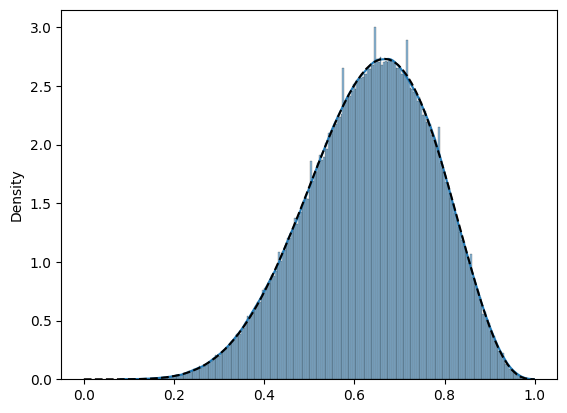

In [34]:
sns.histplot(p[:1000000], kde=True, stat='density')
x = tf.linspace(0.,1,100)
plt.plot(x, tfd.Beta(W+1, L+1).prob(x), '--k');

### Extension of 2.8-2.9 with vectorized JAX code

As with tensorflow, with JAX we can calculate many trajectories in parallel on one or more GPUs.  This code will calculate one billion samples from the posterior in a few seconds:

In [35]:
# combine the entire step into a function to keep the data on the GPU
@jax.jit
def metropolis_step(p_old, W, L, seed):
    seed1, seed2 = jrandom.split(seed)
    p_new = jtfd.Normal(p_old, 0.1).sample(seed=seed1)
    p_new = jnp.abs(p_new)
    p_new = jnp.minimum(p_new, 2 - p_new)
    qprev = jtfd.Binomial(W + L, probs=p_old).prob(W)
    qnew = jtfd.Binomial(W + L, probs=p_new).prob(W)
    return jnp.where(
        jtfd.Uniform().sample(p_old.shape, seed=seed2) < qnew/qprev,
        p_new,
        p_old
    )

n_samples = 1000
n_replicates = 1000000
runin = 100
jp = [0.5*jnp.ones(n_replicates)]
W = 6.
L = 3.

key = jrandom.key(42)
for i in range(1,n_samples + runin):
    key, seed = jrandom.split(key)
    jp.append(metropolis_step(jp[-1], W, L, seed=seed))
    
jp = jnp.concat(jp[runin:])

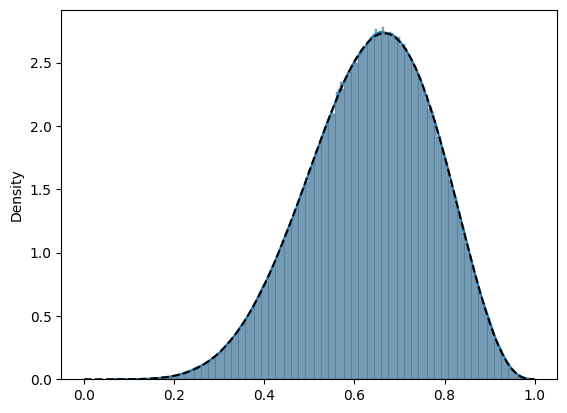

In [36]:
sns.histplot(jp[:1000000], kde=True, stat='density')
x = jnp.linspace(0.,1,100)
plt.plot(x, jtfd.Beta(W+1, L+1).prob(x), '--k');

## Practice

### 2E1

2

### 2E2

3

### 2E3

1

### 2E4

Although in principle whether my finger lands on water is a deterministic process, my lack of knowledge of the details of the process leaves me with enough uncertainty that mutiple outcomes from the process seem credible.  If forced to quantify the degree of credibility of my finger landing on water, I might imagine assigning a weighted sum of credibility (based on both intuition and prior observations) across all models of the events of the globe tossing I can imagine. Then 70 percent of that credibility belongs to models of future events where my finger ends on on water.

### 2M1

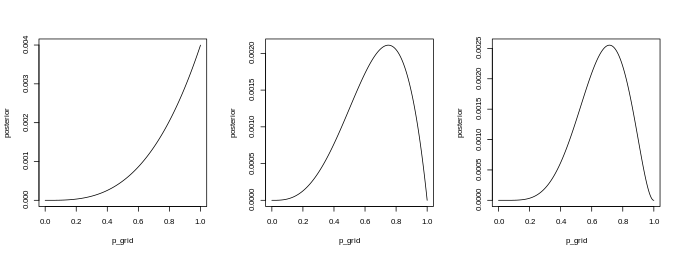

In [37]:
%%R -w 24 -h 9 -u cm

plot_posteriors = function (total_count, water_count, title, num_points=1000,
                        prior= function (p) {rep(1, length(p))}) {
    p_grid <- seq(from=0, to=1, length.out=num_points)
    prior_grid <- prior(p_grid)
    likelihood <- dbinom(water_count, total_count, p_grid)
    unnormalized_posterior <- likelihood * prior_grid
    posterior <- unnormalized_posterior / sum(unnormalized_posterior)
    plot(p_grid, posterior, type="l")
}

par(mfrow=c(1,3))
plot_posteriors(3, 3, "1) WWW")
plot_posteriors(4, 3, "2) WWWL")
plot_posteriors(7, 5, "3) LWWLWWW")

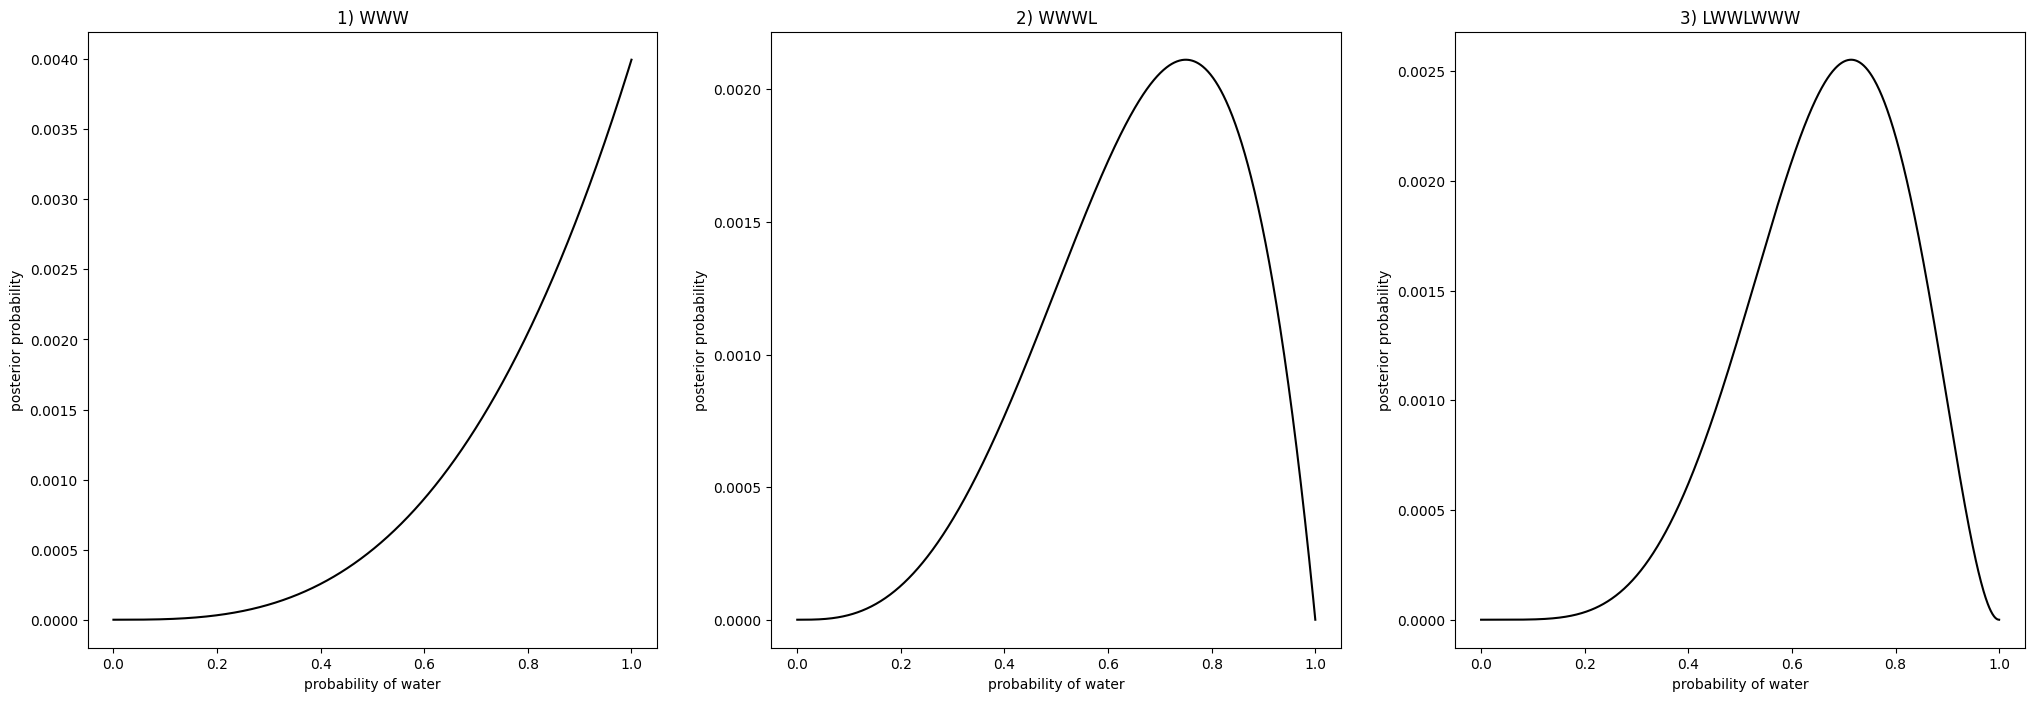

In [38]:
def plot_posteriors(ax, total_count, water_count, title, num_points=1000, 
                    prior=tf.ones_like):
    p_grid = tf.linspace(0., 1., num_points)
    prior_grid = prior(p_grid)
    likelihood = tfd.Binomial(total_count=total_count, probs=p_grid).prob(
        water_count)
    unnormalized_posterior = likelihood * prior_grid
    posterior = unnormalized_posterior / tfm.reduce_sum(unnormalized_posterior)
    ax.plot(p_grid, posterior, "-k")
    ax.set_xlabel("probability of water")
    ax.set_ylabel("posterior probability")
    ax.set_title(title);

fig, axs = plt.subplots(1, 3, figsize=(25,8))
plot_posteriors(axs[0], 3, 3, "1) WWW")
plot_posteriors(axs[1], 4, 3, "2) WWWL")
plot_posteriors(axs[2], 7, 5, "3) LWWLWWW")

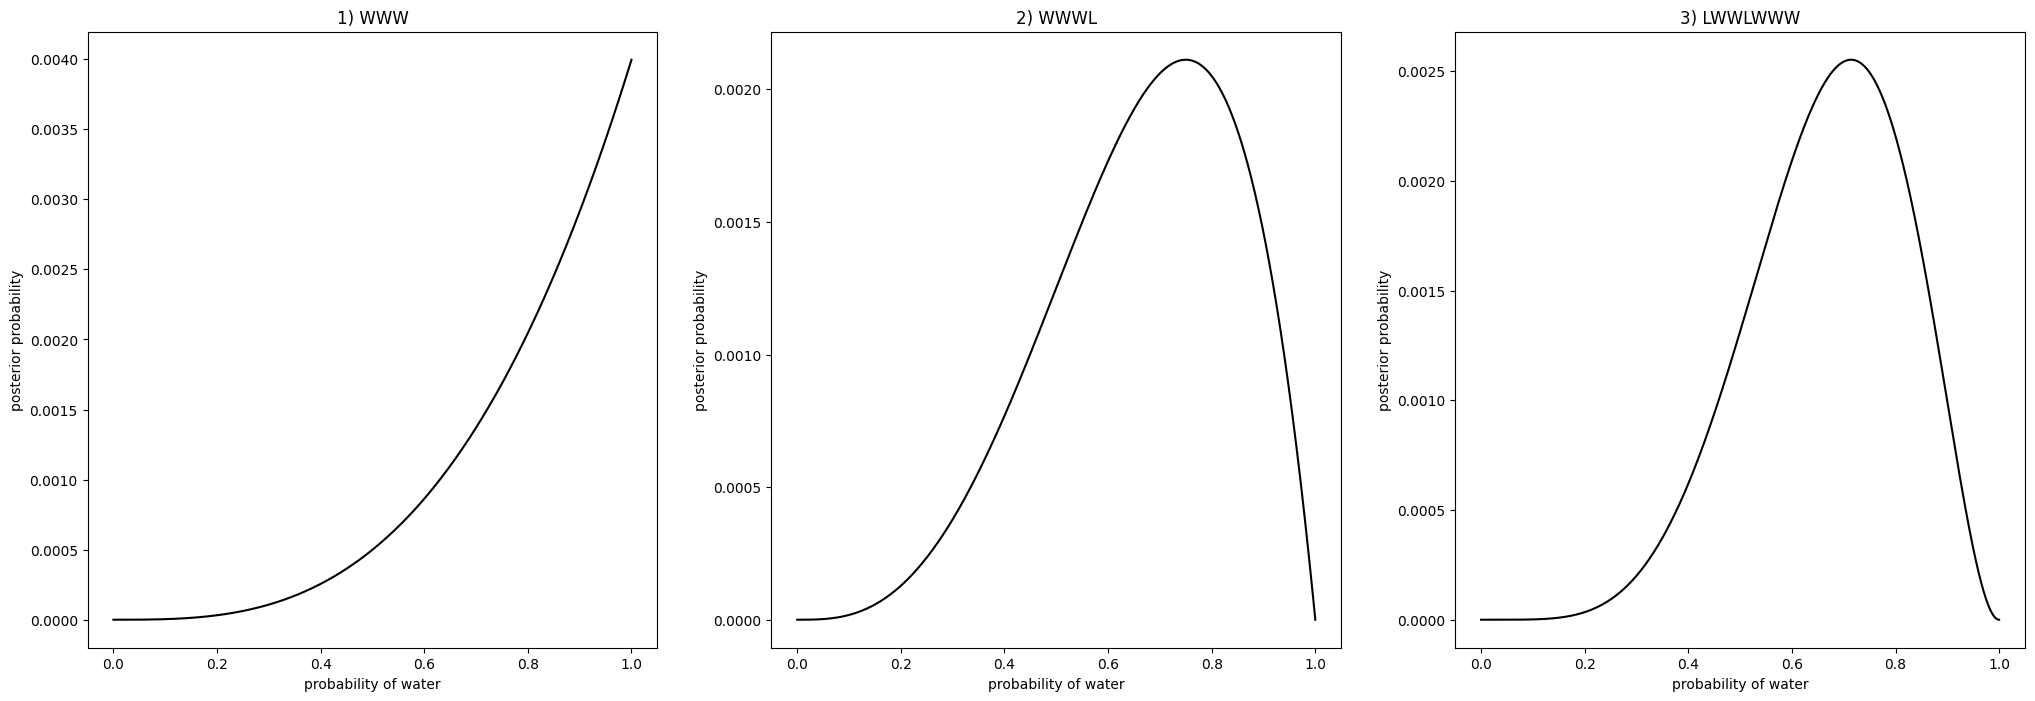

In [39]:
def jplot_posteriors(ax, total_count, water_count, title, num_points=1000, 
                    prior=jnp.ones_like):
    p_grid = jnp.linspace(0., 1., num_points)
    prior_grid = prior(p_grid)
    likelihood = jtfd.Binomial(total_count=total_count, probs=p_grid).prob(
        water_count)
    unnormalized_posterior = likelihood * prior_grid
    posterior = unnormalized_posterior / unnormalized_posterior.sum()
    ax.plot(p_grid, posterior, "-k")
    ax.set_xlabel("probability of water")
    ax.set_ylabel("posterior probability")
    ax.set_title(title);

fig, axs = plt.subplots(1, 3, figsize=(25,8))
jplot_posteriors(axs[0], 3, 3, "1) WWW")
jplot_posteriors(axs[1], 4, 3, "2) WWWL")
jplot_posteriors(axs[2], 7, 5, "3) LWWLWWW")

### 2M2

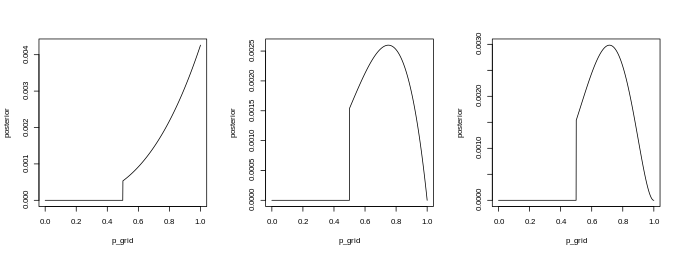

In [40]:
%%R -w 24 -h 9 -u cm

prior = function (p) { p > 0.5 }

par(mfrow=c(1,3))
plot_posteriors(3, 3, "1) WWW", prior=prior)
plot_posteriors(4, 3, "2) WWWL", prior=prior)
plot_posteriors(7, 5, "3) LWWLWWW", prior=prior)

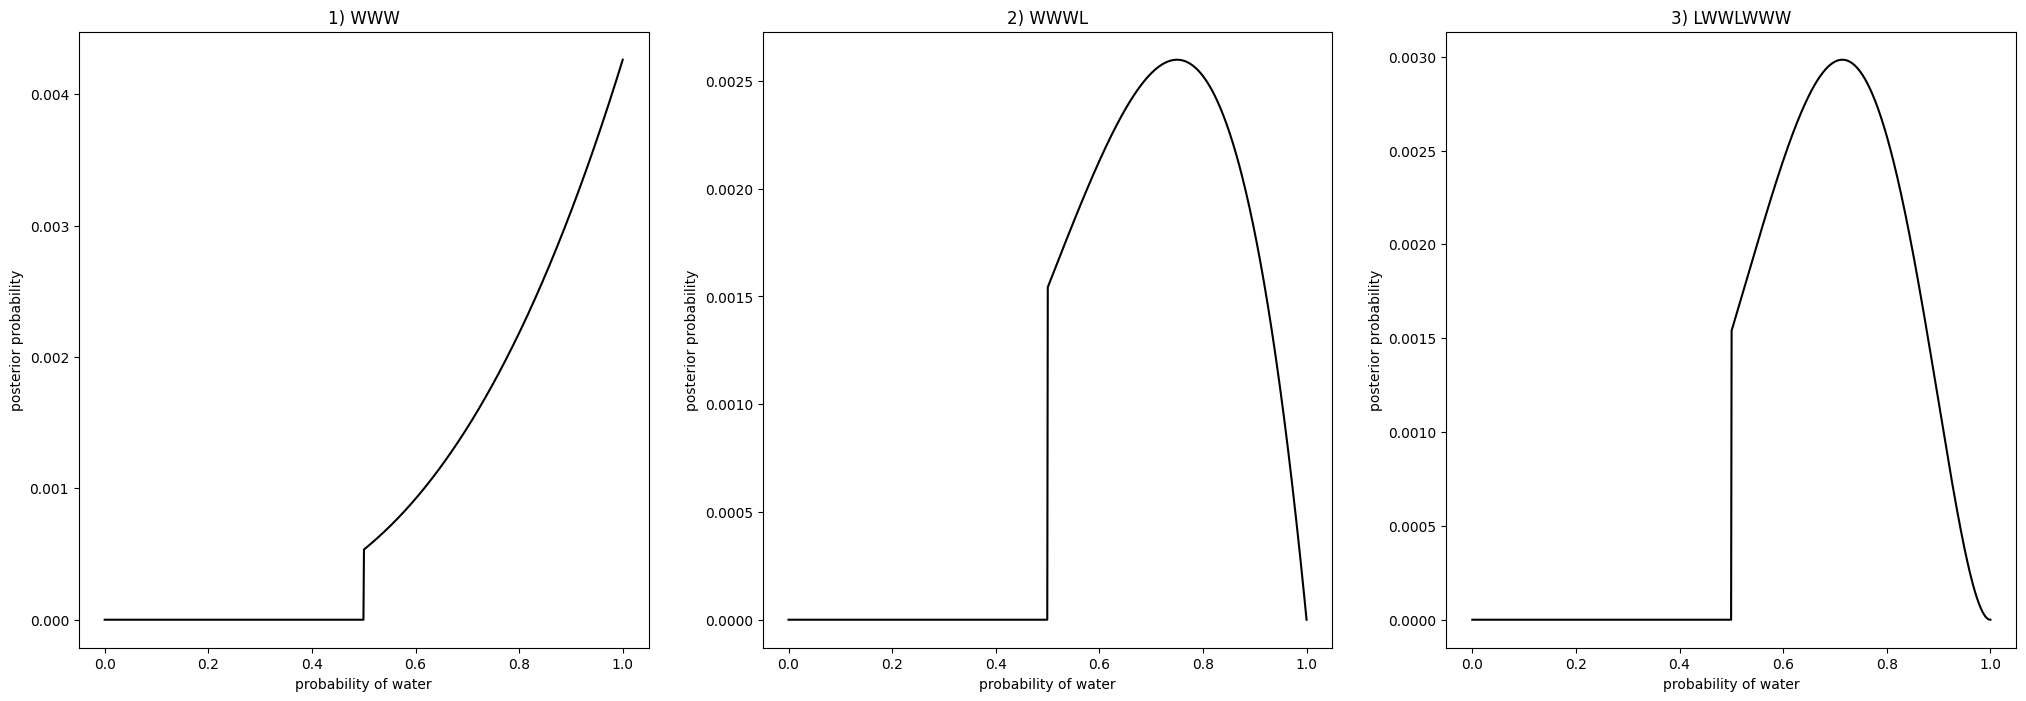

In [41]:
prior = lambda p : tf.where(p < 0.5, tf.zeros_like(p), tf.ones_like(p))

fig, axs = plt.subplots(1, 3, figsize=(25,8))
plot_posteriors(axs[0], 3, 3, "1) WWW", prior=prior)
plot_posteriors(axs[1], 4, 3, "2) WWWL", prior=prior)
plot_posteriors(axs[2], 7, 5, "3) LWWLWWW", prior=prior)

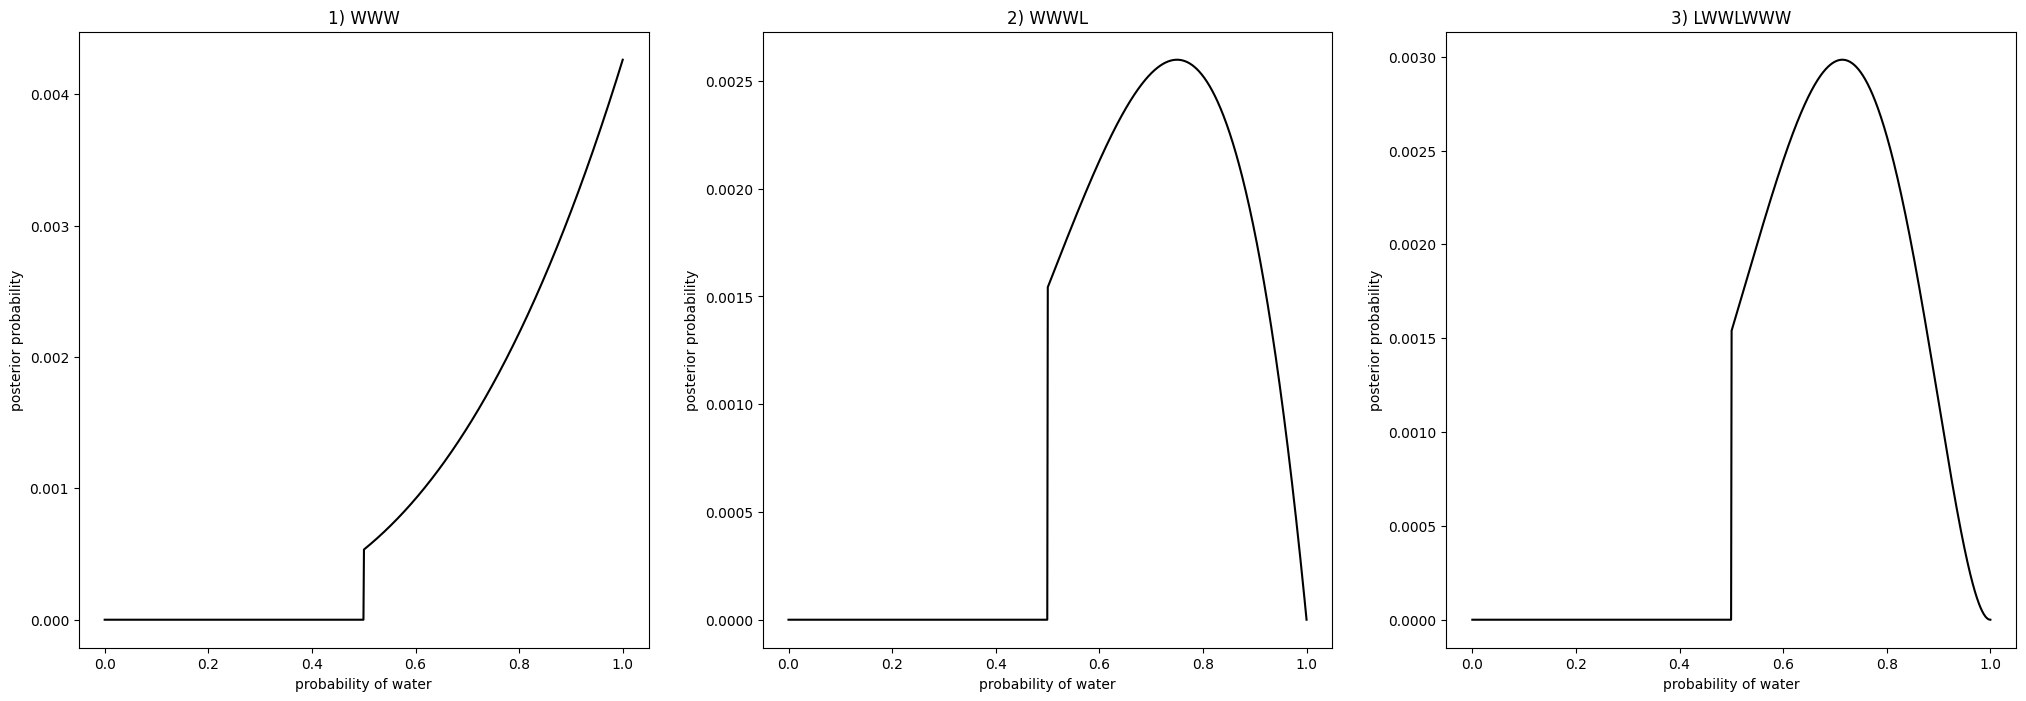

In [42]:
prior = lambda p : jnp.where(p < 0.5, jnp.zeros_like(p), jnp.ones_like(p))

fig, axs = plt.subplots(1, 3, figsize=(25,8))
jplot_posteriors(axs[0], 3, 3, "1) WWW", prior=prior)
jplot_posteriors(axs[1], 4, 3, "2) WWWL", prior=prior)
jplot_posteriors(axs[2], 7, 5, "3) LWWLWWW", prior=prior)

### 2M3

$$ 
\begin{align}
\mathrm{Pr}(\mathrm{Earth} | \mathrm{land})
    &= \frac{\mathrm{Pr}(\mathrm{land} | \mathrm{Earth}) \mathrm{Pr}(\mathrm{Earth})}{
        \mathrm{Pr}(\mathrm{land})} \\
    &= \frac{\mathrm{Pr}(\mathrm{land} | \mathrm{Earth}) \mathrm{Pr}(\mathrm{Earth})}{
        \mathrm{Pr}(\mathrm{land} | \mathrm{Earth}) \mathrm{Pr}(\mathrm{Earth}) +
        \mathrm{Pr}(\mathrm{land} | \mathrm{Mars}) \mathrm{Pr}(\mathrm{Mars})
        } \\
    &= \frac{\mathrm{Pr}(\mathrm{land} | \mathrm{Earth}) \mathrm{Pr}(\mathrm{Earth})}{
        \mathrm{Pr}(\mathrm{land} | \mathrm{Earth}) \mathrm{Pr}(\mathrm{Earth}) +
        \mathrm{Pr}(\mathrm{land} | \mathrm{Mars}) \mathrm{Pr}(\mathrm{Mars})
        } \\
    &= \frac{(1 - 0.7) \cdot (0.5)}{
        (1 - 0.7) \cdot (0.5) +
        (1) \cdot (0.5)
        } \\
    &= \frac{3}{13} \\
    &\approx 0.23
\end{align}
$$


In [43]:
# simulation

n_trials = 1000000
earth = tfd.Binomial(1, probs=0.5).sample(n_trials)
land = tf.where(earth == 1., tfd.Binomial(1, probs= 0.3).sample(n_trials), 
                tf.ones(n_trials))
earth_given_land = tf.boolean_mask(earth, land == 1)
print(f'{tfm.reduce_mean(earth_given_land):.3}')

0.231


In [44]:
# simulation

n_trials = 1000000
seed1, seed2 = jrandom.split(jrandom.key(23))
earth = jtfd.Binomial(1, probs=0.5).sample(n_trials, seed=seed1)
land = jnp.where(
    earth == 1.,
    jtfd.Binomial(1, probs= 0.3).sample(n_trials, seed=seed2), 
    jnp.ones(n_trials)
)
earth_given_land = tf.boolean_mask(earth, land == 1)
print(f'{tfm.reduce_mean(earth_given_land):.3}')

0.23


### 2M4

| Card | Side 1 | Side 2 |
|------|--------|--------|
|    0 | Black  | Black  |
|    0 | Black  | White  |
|    0 | White  | White  |

We assume we are equally likely to be viewing any of the three black sides of a card in the deck.  We can see that two out of those three black sides have a black side on the opposite side of the card, so the probability that the other side is black is 2/3.

In [45]:
# simulation

n_trials = 1000000
sides_black = tf.constant([[1,1], [1,0], [0,0]])
num_cards = sides_black.shape[0]
first_cards = tf.random.categorical([tf.ones(num_cards)], n_trials)[0]
first_top_sides = tf.random.categorical([tf.ones(2)], n_trials)[0]
first_sides_black = tf.gather(sides_black, first_cards)
first_top_sides_black = tf.where(first_top_sides == 0, first_sides_black[:,0], 
    first_sides_black[:,1])
first_bottom_sides_black = tf.where(first_top_sides == 1, 
    first_sides_black[:,0], first_sides_black[:,1])
first_bottom_sides_black_given_top_sides_black = tf.boolean_mask(
    first_bottom_sides_black, first_top_sides_black == 1)
p = tfm.reduce_mean(
        tf.cast(first_bottom_sides_black_given_top_sides_black, tf.float32))
print(f'{p:.3}')

0.667


In [46]:
# simulation

n_trials = 1000000
sides_black = jnp.array([[1,1], [1,0], [0,0]])
num_cards = sides_black.shape[0]
seed1, seed2 = jrandom.split(jrandom.key(42))
first_cards = jrandom.choice(
    a=num_cards, shape=(n_trials,), key=seed1)
first_top_sides = jrandom.choice(
    a=2, shape=(n_trials,), key=seed2)
first_top_sides_black = sides_black[first_cards, first_top_sides]
first_bottom_sides_black = sides_black[first_cards, 1 - first_top_sides]
first_bottom_sides_black_given_top_sides_black = first_bottom_sides_black[
    first_top_sides_black == 1]
p = first_bottom_sides_black_given_top_sides_black.mean()
print(f'{p:.3}')

0.667


### 2M5

Given 4 of the 5 black sides in the new deck are paired with a black side on the opposite side, the probability is 4/5.

In [47]:
# simulation

n_trials = 1000000
sides_black = tf.constant([[1,1], [1,0], [0,0], [1,1]])
num_cards = sides_black.shape[0]
first_cards = tf.random.categorical([tf.ones(num_cards)], n_trials)[0]
first_top_sides = tf.random.categorical([tf.ones(2)], n_trials)[0]
first_sides_black = tf.gather(sides_black, first_cards)
first_top_sides_black = tf.where(first_top_sides == 0, first_sides_black[:,0],
    first_sides_black[:,1])
first_bottom_sides_black = tf.where(first_top_sides == 1,
    first_sides_black[:,0], first_sides_black[:,1])
first_bottom_sides_black_given_top_sides_black = tf.boolean_mask(
    first_bottom_sides_black, first_top_sides_black == 1)
p = tfm.reduce_mean(
    tf.cast(first_bottom_sides_black_given_top_sides_black, tf.float32))
print(f'{p:.3}')

0.8


In [48]:
# simulation

n_trials = 1000000
sides_black = jnp.array([[1,1], [1,0], [0,0], [1,1]])
num_cards = sides_black.shape[0]
seed1, seed2 = jrandom.split(jrandom.key(23))
first_cards = jrandom.choice(
    a=num_cards, shape=(n_trials,), key=seed1)
first_top_sides = jrandom.choice(
    a=2, shape=(n_trials,), key=seed2)
first_top_sides_black = sides_black[first_cards, first_top_sides]
first_bottom_sides_black = sides_black[first_cards, 1 - first_top_sides]
first_bottom_sides_black_given_top_sides_black = first_bottom_sides_black[
    first_top_sides_black == 1]
p = first_bottom_sides_black_given_top_sides_black.mean()
print(f'{p:.3}')

0.8


### 2M6

With the new arrangement we have 1 way to pull the single B/B card from the deck (accounting for 2 ways to see a black side) and 2 ways to pull the single B/W card from the bag (accounting for 2 ways to see a black side); thus the probability is 2/4 = 1/2.

In [49]:
# simulation

n_trials = 10000000
sides_black = tf.constant([[1,1], [1,0], [0,0]])
num_cards = sides_black.shape[0]
first_cards = tf.random.categorical(tfm.log([[1.,2.,3.]]), n_trials)[0]
first_top_sides = tf.random.categorical([tf.ones(2)], n_trials)[0]
first_sides_black = tf.gather(sides_black, first_cards)
first_top_sides_black = tf.where(first_top_sides == 0, first_sides_black[:,0],
    first_sides_black[:,1])
first_bottom_sides_black = tf.where(first_top_sides == 1,
    first_sides_black[:,0], first_sides_black[:,1])
first_bottom_sides_black_given_top_sides_black = tf.boolean_mask(
    first_bottom_sides_black, first_top_sides_black == 1)
p = tfm.reduce_mean(
    tf.cast(first_bottom_sides_black_given_top_sides_black, tf.float32))
print(f'{p:.3}')

0.5


In [50]:
# simulation

n_trials = 10000000
#sides_black = jnp.array([[1,1]] * 1 + [[1,0]] * 2 + [[0,0]] * 3)
sides_black = jnp.array([[1,1], [1,0], [0,0]])
num_cards = sides_black.shape[0]
seed1, seed2 = jrandom.split(jrandom.key(42))
first_cards = jrandom.choice(
    a=num_cards, shape=(n_trials,), p=jnp.array([1/6,2/6,3/6]), key=seed1)
first_top_sides = jrandom.choice(
    a=2, shape=(n_trials,), key=seed2)
first_top_sides_black = sides_black[first_cards, first_top_sides]
first_bottom_sides_black = sides_black[first_cards, 1 - first_top_sides]
first_bottom_sides_black_given_top_sides_black = first_bottom_sides_black[
    first_top_sides_black == 1]
p = first_bottom_sides_black_given_top_sides_black.mean()
print(f'{p:.3}')

0.5


### 2M7

Our possible draws are 2 $\times$ BB+BW (one for each face of BB), 2 $\times$ 2 $\times$ BB+WW (one for each face of each card), and 2 $\times$ BW+WW (one for each face of WW).  Thus the probability is 6/8, or 0.75.

In [51]:
# simulation

n_trials = 1000000
sides_black = tf.constant([[1,1], [1,0], [0,0]])
num_cards = sides_black.shape[0]
first_cards = tf.random.categorical([tf.ones(num_cards)], n_trials)[0]
first_top_sides = tf.random.categorical([tf.ones(2)], n_trials)[0]
first_sides_black = tf.gather(sides_black, first_cards)
first_top_sides_black = tf.where(first_top_sides == 0, first_sides_black[:,0],
    first_sides_black[:,1])
first_bottom_sides_black = tf.where(first_top_sides == 1,
    first_sides_black[:,0], first_sides_black[:,1])
second_cards_post_draw1 = tf.random.categorical([tf.ones(num_cards-1)],
    n_trials)[0]
second_cards = tf.where(second_cards_post_draw1 >= first_cards,
    second_cards_post_draw1 + 1, second_cards_post_draw1)
second_top_sides = tf.random.categorical([tf.ones(2)], n_trials)[0]
second_sides_black = tf.gather(sides_black, second_cards)
second_top_sides_black = tf.where(second_top_sides == 0,
    second_sides_black[:,0], second_sides_black[:,1])

first_bottom_sides_black_given_top_sides_black_white = tf.boolean_mask(
    first_bottom_sides_black, tf.logical_and(first_top_sides_black == 1,
    second_top_sides_black == 0))
p = tfm.reduce_mean(
    tf.cast(first_bottom_sides_black_given_top_sides_black_white, tf.float32))
print(f'{p:.3}')

0.751


In [52]:
# simulation

n_trials = 1000000
sides_black = jnp.array([[1,1], [1,0], [0,0]])
num_cards = sides_black.shape[0]
seed1, seed2, seed3, seed4 = jrandom.split(jrandom.key(42), 4)

first_cards = jrandom.choice(a=num_cards, shape=(n_trials,), key=seed1)
first_top_sides = jrandom.choice(a=2, shape=(n_trials,), key=seed2)
first_top_sides_black = sides_black[first_cards, first_top_sides]
first_bottom_sides_black = sides_black[first_cards, 1 - first_top_sides]

# index into remaining cards
second_cards_postdraw = jrandom.choice(
    a=num_cards - 1, shape=(n_trials,), key=seed3)
# index into original cards
second_cards = jnp.where(
    second_cards_postdraw < first_cards,
    second_cards_postdraw,
    second_cards_postdraw + 1
)
second_top_sides = jrandom.choice(a=2, shape=(n_trials,), key=seed4)
second_top_sides_black = sides_black[second_cards, second_top_sides]

black_sides_consistent_with_observation = first_bottom_sides_black[
    (first_top_sides_black == 1) * (second_top_sides_black == 0)]
p = black_sides_consistent_with_observation.mean()
print(f'{p:.3}')

0.75


### 2H1

Let $A$ and $\neg A$ represent the Panda as being species A or B and $T_1$ and $T_2$ represent twins on the first birth second birth, respectively. Then

$$
\begin{align}
Pr(T_2 | T_1) &= Pr(T_2 | A, T_1) Pr(A | T_1) + Pr(T_2 | \neg A, T_1) Pr(\neg A | T_1) \\
&= Pr(T_2 | A) Pr(A | T_1) + Pr(T_2 | \neg A) Pr(\neg A | T_1) \\
&= Pr(T_2 | A) \frac{Pr(T_1 | A) Pr(A)}{Pr(T_1)} + Pr(T_2 | \neg A) \frac{Pr(T_1 | \neg A) Pr(\neg A)}{Pr(T_1)} \\
&= \frac{Pr(T_2 | A) Pr(T_1 | A) Pr(A) + Pr(T_2 | \neg A) Pr(T_1 | \neg A) Pr(\neg A)}{Pr(T_1)} \\
&= \frac{Pr(T_2 | A) Pr(T_1 | A) Pr(A) + Pr(T_2 | \neg A) Pr(T_1 | \neg A) Pr(\neg A)}{Pr(T_1 | A) P(A) + Pr(T_1 | \neg A) Pr(\neg A)} \\
&= \frac{(10\%) (10\%) (50\%) + (20\%) (20\%) (50\%)}{(10\%) (50\%) + (20\%) (50\%)} \\
&= \frac{1}{6}.
\end{align}
$$

In [53]:
# simulation

n_trials = 100000000
prob_twins_by_species = tf.constant([0.1, 0.2])
species = tf.random.categorical([tf.ones(2)], n_trials)[0]
prob_twins = tf.gather(prob_twins_by_species, species)
first_twins = tfd.Uniform().sample(n_trials) <= prob_twins
second_twins = tfd.Uniform().sample(n_trials) <= prob_twins

second_twins_given_first_twins = tf.boolean_mask(second_twins, first_twins)
p = tfm.reduce_mean(tf.cast(second_twins_given_first_twins, tf.float32))
print(f'Pr(T2|T1) = {p:.3}')

Pr(T2|T1) = 0.167


In [54]:
# simulation

n_trials = 100000000
key, seed1, seed2, seed3 = jrandom.split(jrandom.key(42),4)
prob_twins_by_species = jnp.array([0.1, 0.2])
jspecies = jrandom.choice(a=2, shape=(n_trials,), key=seed1)
jprob_twins = prob_twins_by_species[jspecies]
jfirst_twins = jrandom.uniform(shape=(n_trials,), key=seed2) <= jprob_twins
jsecond_twins = jrandom.uniform(shape=(n_trials,), key=seed3) <= jprob_twins

jsecond_twins_given_first_twins = jsecond_twins[jfirst_twins == 1]
print(f'Pr(T2|T1) = {jsecond_twins_given_first_twins.mean():.3}')

Pr(T2|T1) = 0.167


### 2H2

$$
\begin{align}
Pr(A | T_1) & = \frac{Pr(T_1 | A) Pr(A)}{Pr(T_1)} \\
& = \frac{Pr(T_1 | A) Pr(A)}{Pr(T_1 | A) P(A) + Pr(T_1 | \neg A) Pr(\neg A)} \\
&= \frac{(10\%) (50\%)}{(10\%) (50\%) + (20\%) (50\%)} \\
&= \frac{1}{3}.
\end{align}
$$

In [55]:
# simulation, continued
species_a_given_first_twins = tf.boolean_mask(species == 0, first_twins)
p = tfm.reduce_mean(tf.cast(species_a_given_first_twins, tf.float32))
print(f'Pr(A|T1) = {p:.3}')

Pr(A|T1) = 0.333


In [56]:
# simulation, continued
jspecies_a_given_first_twins = jspecies[jfirst_twins == 1] == 0
print(f'Pr(A|T1) = {jspecies_a_given_first_twins.mean():.3}')

Pr(A|T1) = 0.333


### 2H3

$$
\begin{align}
Pr(A | T_1, \neg T2) 
&= \frac{Pr( T_1, \neg T_2 | A ) Pr(A)}{Pr(T_1, \neg T_2)} \\
&= \frac{Pr( T_1, \neg T_2 | A ) Pr(A)}{Pr(T_1, \neg T_2 | A) Pr(A) + Pr(T_1, \neg T_2 | \neg A) Pr(\neg A)} \\
&= \frac{Pr( T_1 | A ) Pr( \neg T_2 | A) Pr(A)}{Pr( T_1 | A ) Pr( \neg T_2 | A) Pr(A) + Pr(T_1 | \neg A ) Pr( \neg T_2 | \neg A) Pr(\neg A)} \\
&= \frac{(10\%) (90\%) (50\%)}{(10\%) (90\%) (50\%) + (20\%) (80\%) (50\%)} \\
&= \frac{9}{25} \\
&= 36\%
\end{align}
$$

In [57]:
# simulation, continued
species_a_given_first_twins_second_singleton = tf.boolean_mask(
    species == 0, tf.logical_and(first_twins, second_twins==False))
p = tfm.reduce_mean(tf.cast(species_a_given_first_twins_second_singleton,
                            tf.float32))
print(f'Pr(A|T1,~T2) = {p:.3}')

Pr(A|T1,~T2) = 0.36


In [58]:
# simulation, continued
jspecies_a_given_first_twins_second_singleton = (
    0 == jspecies[jfirst_twins * (jsecond_twins == 0)]
)

print(f'Pr(A|T1) = {jspecies_a_given_first_twins_second_singleton.mean():.3}')

Pr(A|T1) = 0.36


### 2H4

Let $S$ represent a positive test.

$$
\begin{align}
Pr(A|S) &= \frac{Pr(S|A) Pr(A)}{Pr(S)} \\
        &= \frac{Pr(S|A) Pr(A)}{Pr(S|A) Pr(A) + Pr(S|\neg A) Pr(\neg A)} \\
        &= \frac{(0.8) (0.5)}{(0.8) (0.5) + (0.35) (0.5)} \\
        &= \frac{16}{23} \\
        &\approx 0.696.
\end{align}
$$

Assuming that $S$ conditioned on $A$ is independent of $T_1$ and $T_2$, we also have

$$
\begin{align}
Pr(A|S,T_1,\neg T_2)
    &= \frac{Pr(S,T_1,\neg T_2|A) Pr(A)}{Pr(S, T_1, \neg T_2)} \\
    &= \frac{Pr(S|A) \Pr(T_1,\neg T_2|A) Pr(A)}{
        Pr(S, T_1, \neg T_2 | A) Pr(A) + Pr(S, T_1, \neg T_2 | \neg A) Pr(\neg A)} \\
    &= \frac{Pr(S|A) \Pr(T_1|A) \Pr(\neg T_2|A) Pr(A)}{
        Pr(S | A) Pr(T_1 | A) Pr(\neg T_2 | A) Pr(A) + Pr(S | \neg A) Pr(T_1 | \neg A) Pr(\neg T_2 | \neg A) Pr(\neg A)} \\    
    &= \frac{ (0.8)(0.1)(0.9)(0.5) }{ (0.8)(0.1)(0.9)(0.5) + (0.35)(0.2)(0.8)(0.5) } \\
    &= \frac{9}{16} \\
    &\approx 0.563
\end{align}
$$

In [59]:
# simulation, continued
prob_test_positive_by_species = tf.constant([0.8, 1 - 0.65])
prob_test_positive = tf.gather(prob_test_positive_by_species, species)
test_positive = tfd.Uniform().sample(n_trials) <= prob_test_positive

species_a_given_test_positive = tf.boolean_mask(species == 0, test_positive)
p = tfm.reduce_mean(tf.cast(species_a_given_test_positive, tf.float32))
print(f'Pr(A|S) = {p:.3f}')

species_a_given_test_positive_and_births = tf.boolean_mask(species == 0,
    tf.logical_and(tf.logical_and(test_positive, first_twins), 
                   second_twins==False))
p = tfm.reduce_mean(
    tf.cast(species_a_given_test_positive_and_births, tf.float32))
print(f'Pr(A|S,T1,~T2) = {p:.3f}')

Pr(A|S) = 0.696
Pr(A|S,T1,~T2) = 0.562


In [60]:
# simulation, continued
prob_test_positive_by_species = jnp.array([0.8, 1 - 0.65])
prob_test_positive = prob_test_positive_by_species[jspecies]

key, seed = jrandom.split(key)
test_positive = jrandom.uniform(shape=(n_trials,), key=seed) <= prob_test_positive

species_a_given_test_positive = 0 == jspecies[test_positive]
print(f'Pr(A|S) = {species_a_given_test_positive.mean():.3f}')

species_a_given_test_positive_and_births = 0 == jspecies[
    test_positive * jfirst_twins * (jsecond_twins == 0)
]
print(f'Pr(A|S,T1,~T2) = {species_a_given_test_positive_and_births.mean():.3f}')

Pr(A|S) = 0.696
Pr(A|S,T1,~T2) = 0.562
